In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import pickle
import random
from PIL import Image
from math import *

In [2]:
def tensor_imshow(im_tensor,cannel):
    b,c,h,w=im_tensor.shape
    if c==1:
        plt.imshow(im_tensor.squeeze().detach().numpy())
    else:
        plt.imshow(im_tensor.squeeze().detach().numpy()[cannel,:])
        
def get_training_fragment(frag_size,im):
    h,w,c=im.shape
    n=random.randint(0,int(h/frag_size)-1)
    m=random.randint(0,int(w/frag_size)-1)
    
    shape=frag_size/4
    vt_h=math.ceil((h+1)/shape)
    vt_w=math.ceil((w+1)/shape)
    vt=np.zeros([vt_h,vt_w])
    vt_h_po=round((vt_h-1)*(n*frag_size/(h-1)+(n+1)*frag_size/(h-1))/2)
    vt_w_po=round((vt_w-1)*(m*frag_size/(w-1)+(m+1)*frag_size/(w-1))/2)
    vt[vt_h_po,vt_w_po]=1
    vt = np.float32(vt)
    vt=torch.from_numpy(vt.reshape(1,1,vt_h,vt_w))
    
    return im[n*frag_size:(n+1)*frag_size,m*frag_size:(m+1)*frag_size,:],vt

def write_result_in_file(result,file_name):
    n=0
    with open(filename,'w') as file:
        for i in range(len(result)):
            while n<result[i][0]:
                s=str(n)
                n=n+1
                s=s+"\n"
                file.write(s)
            s=str(result[i][0])+" "+str(result[i][1])+" "+str(result[i][2])+" "+str(result[i][3])
            s=s+"\n"
            n=n+1
            file.write(s)
        file.close()
    
    
def img2tensor(im):
    im=np.array(im,dtype="float32")
    tensor_cv = torch.from_numpy(np.transpose(im, (2, 0, 1)))
    im_tensor=tensor_cv.unsqueeze(0)
    return im_tensor

def show_coordonnee(position_pred):
    map_corre=position_pred.squeeze().detach().numpy()
    score=sum(sum(map_corre))
    h,w=map_corre.shape
    max_value=map_corre.max()
    coordonnee=np.where(map_corre==max_value)
    return score,coordonnee[0].mean()/h,coordonnee[1].mean()/w
    """
    if len(coordonnee[0])==1:
        h_=coordonnee[0][0]/h
        w_=coordonnee[1][0]/w
        return max_value,h_,w_
    else:
        return -1,-1,-1
    """
def show_coordonnee_2(position_pred):
    max_value=position_pred.max()
    coordonnee=np.where(position_pred==max_value)
    return int(coordonnee[0].mean()),int(coordonnee[1].mean())

def test_fragment32_32(frag,seuillage):
    a=frag[:,:,0]+frag[:,:,1]+frag[:,:,2]
    mask = (a == 0)
    arr_new = a[mask]
    if arr_new.size/a.size<=(1-seuillage):
        return True
    else:
        return False
    
def patch_rotated_mask(frag_size):
    Mask=np.ones([frag_size,frag_size,3],dtype='uint8')
    Im_Mask=Image.fromarray(Mask)
    for i in range(18):
        Im=Im_Mask.rotate(20*i)
        m=np.array(Im)
        Mask=Mask*m
    return Mask

def save_net(file_path,net):
    pkl_file = open(file_path, 'wb')
    pickle.dump(net,pkl_file)
    pkl_file.close()
    
def load_net(file_path):   
    pkl_file = open(file_path, 'rb')
    net= pickle.load(pkl_file)
    pkl_file.close()
    return net

In [63]:
def ini():
    kernel=torch.zeros([8,3,3,3])
    array_0=np.array([[1,2,1],[0,0,0],[-1,-2,-1]],dtype='float32')
    array_1=np.array([[2,1,0],[1,0,-1],[0,-1,-2]],dtype='float32')
    array_2=np.array([[1,0,-1],[2,0,-2],[1,0,-1]],dtype='float32')
    array_3=np.array([[0,-1,-2],[1,0,-1],[2,1,0]],dtype='float32')
    array_4=np.array([[-1,-2,-1],[0,0,0],[1,2,1]],dtype='float32')
    array_5=np.array([[-2,-1,0],[-1,0,1],[0,1,2]],dtype='float32')
    array_6=np.array([[-1,0,1],[-2,0,2],[-1,0,1]],dtype='float32')
    array_7=np.array([[0,1,2],[-1,0,1],[-2,-1,0]],dtype='float32')
    for i in range(3):
        kernel[0,i,:]=torch.from_numpy(array_0)
        kernel[1,i,:]=torch.from_numpy(array_1)
        kernel[2,i,:]=torch.from_numpy(array_2)
        kernel[3,i,:]=torch.from_numpy(array_3)
        kernel[4,i,:]=torch.from_numpy(array_4)
        kernel[5,i,:]=torch.from_numpy(array_5)
        kernel[6,i,:]=torch.from_numpy(array_6)
        kernel[7,i,:]=torch.from_numpy(array_7)
    return torch.nn.Parameter(kernel,requires_grad=True) 

def kernel_add_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n/2)*int(m/2)
    for i in range(int(n/2)):
        for j in range(int(m/2)):
            kernel_add=np.zeros([1,input_canal],dtype='float32')
            kernel_add[0,i*2*m+j*2]=1
            kernel_add[0,i*2*m+j*2+1]=1
            kernel_add[0,(i*2+1)*m+j*2]=1
            kernel_add[0,(i*2+1)*m+j*2+1]=1
            if i==0 and j==0:
                add=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
            else:
                add_=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
                add=torch.cat((add,add_),0)
    return torch.nn.Parameter(add,requires_grad=False) 

def kernel_shift_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n*m)
    
    kernel_shift=torch.zeros([output_canal,input_canal,3,3])
    
    array_0=np.array([[1,0,0],[0,0,0],[0,0,0]],dtype='float32')
    array_1=np.array([[0,0,1],[0,0,0],[0,0,0]],dtype='float32')
    array_2=np.array([[0,0,0],[0,0,0],[1,0,0]],dtype='float32')
    array_3=np.array([[0,0,0],[0,0,0],[0,0,1]],dtype='float32')
    
    kernel_shift_0=torch.from_numpy(array_0)
    kernel_shift_1=torch.from_numpy(array_1)
    kernel_shift_2=torch.from_numpy(array_2)
    kernel_shift_3=torch.from_numpy(array_3)
    
    
    for i in range(n):
        for j in range(m):
            if i==0 and j==0:
                kernel_shift[0,0,:]=kernel_shift_0
            else:
                if i%2==0 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_0
                if i%2==0 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_1
                if i%2==1 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_2
                if i%2==1 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_3
                    
    return torch.nn.Parameter(kernel_shift,requires_grad=False) 

def get_patch(fragment,psize,n,m):
    return fragment[:,:,n*psize:(n+1)*psize,m*psize:(m+1)*psize]

def shift_1pixel(map_corr,num_patch):
    #num_patch:
    #          0 1
    #          2 3
    h,w=map_corr.shape
    map_shifted=torch.zeros([h,w])
    if num_patch==0:
        map_shifted[1:h,1:w]=map_corr[0:h-1,0:w-1]
    if num_patch==1:
        map_shifted[1:h,0:w-1]=map_corr[0:h-1,1:w]
    if num_patch==2:
        map_shifted[0:h-1,1:w]=map_corr[1:h,0:w-1]
    if num_patch==3:
        map_shifted[0:h-1,0:w-1]=map_corr[1:h,1:w]
        
    return map_shifted

def shift_map_corre(n,m,map_corre):
    b,c,h,w=map_corre.shape
    for i in range(n):
        for j in range(m):
            if i%2==0 and j%2==0:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],0)
            if i%2==0 and j%2==1:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],1)
            if i%2==1 and j%2==0:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],2)
            if i%2==1 and j%2==1:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],3)
    return map_corre

class Net(nn.Module):
    def __init__(self,frag_size,psize):
        super(Net, self).__init__()
       
        h_fr=frag_size
        w_fr=frag_size
        
        n=int(h_fr/psize) #n*m patches
        m=int(w_fr/psize)
        
        self.conv1 = nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1)
        self.conv1.weight=ini()
        self.Relu = nn.ReLU(inplace=True)
        self.maxpooling=nn.MaxPool2d(3,stride=2, padding=1)
        
        self.shift1=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
        self.shift1.weight=kernel_shift_ini(n,m)
        self.add1 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
        self.add1.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift2=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift2.weight=kernel_shift_ini(n,m)
            self.add2 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add2.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift3=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift3.weight=kernel_shift_ini(n,m)
            self.add3 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add3.weight=kernel_add_ini(n,m)
        
        
    def get_descripteur(self,img,using_cuda):
        descripteur_img=self.Relu(self.conv1(img))
        b,c,h,w=descripteur_img.shape
        couche_constante=0.5*torch.ones([1,1,h,w])
        if using_cuda:
            couche_constante=couche_constante.cuda()
        descripteur_img=torch.cat((descripteur_img,couche_constante),1)
        descripteur_img_norm=descripteur_img/torch.norm(descripteur_img,dim=1)
        return descripteur_img_norm
    
    def forward(self,img,frag,using_cuda):
        psize=4
        
        descripteur_input1=self.get_descripteur(img,using_cuda)
        descripteur_input2=self.get_descripteur(frag,using_cuda)
        
        b,c,h,w=frag.shape
        n=int(h/psize)
        m=int(w/psize)
        
        for i in range(n):
            for j in range(m):
                if i==0 and j==0:
                    map_corre=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                else:
                    a=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                    map_corre=torch.cat((map_corre,a),1)
        map_corre1=map_corre
        #shift
        
        map_corre=self.maxpooling(map_corre)
        map_corre=self.shift1(map_corre)
        map_corre=self.add1(map_corre)
        
        map_corre2=map_corre
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift2(map_corre)
            map_corre=self.add2(map_corre)
        
        map_corre3=map_corre
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift3(map_corre)
            map_corre=self.add3(map_corre)
        
        b,c,h,w=map_corre.shape
        map_corre=map_corre/(map_corre.max())
        return map_corre,map_corre3,map_corre2,map_corre1

In [4]:
def get_patch_list(frag,frag_size,limite,seuillage):
    n=0
    m=0
    h,w,c=frag.shape
    patch_list=[]
    position_list=[]
    for i in range(4):
        if len(patch_list)>limite and limite!=0:
            break
        for j in range(4):
            if len(patch_list)>limite and limite!=0:
                break
            n_offset=i*4 # n offset
            m_offset=j*4 # m offset
            n=0
            while n+frag_size+n_offset<h:
                m=0
                while m+frag_size+m_offset<w:
                    patch=frag[n+n_offset:n+frag_size+n_offset,m+m_offset:m+frag_size+m_offset,:]
                    if test_fragment32_32(patch,seuillage):
                        patch_list.append(patch)
                        position_list.append([int((n+frag_size/2)+n_offset),int((m+frag_size/2)+m_offset)])
                    m=m+frag_size
                n=n+frag_size
    return patch_list,position_list

In [5]:
def run_net(net,img,frag,frag_size,using_cuda,rotation):
    Img=Image.fromarray(frag)
    frag=np.array(Img.rotate(rotation))
    h,w,c=frag.shape
    n=int(h/frag_size)
    m=int(w/frag_size)
    seuillage=20 #au moin 20 patchs dans les fragments
    limite=4
    frag_list=[]
    position_frag=[]
    for i in range(n):
        for j in range(m):
            frag_32=frag[i*frag_size:(i+1)*frag_size,j*frag_size:(j+1)*frag_size]
            if test_fragment32_32(frag_32,0.5):
                frag_list.append(frag_32)
                position_frag.append([i*frag_size+frag_size/2,j*frag_size+frag_size/2])
    img_tensor=img2tensor(img)
    
    for l in range(limite):
        if len(frag_list)>=seuillage:
            break
        else:
            for i in range(n-1):
                for j in range(m-1):
                    frag_32=frag[i*frag_size+(l+1)*4:(i+1)*frag_size+(l+1)*4,j*frag_size+(l+1)*4:(j+1)*frag_size+(l+1)*4]
                    if test_fragment32_32(frag_32,0.5):
                        frag_list.append(frag_32)
                        position_frag.append([(i*frag_size+frag_size/2)+(l+1)*4,(j*frag_size+frag_size/2)+(l+1)*4])

    if using_cuda:
        img_tensor=img_tensor.cuda()
    
    score_list=[]
    coordonnee_list=[]
    for i in range(len(frag_list)):
        frag_tensor=img2tensor(frag_list[i])
        if using_cuda:
            frag_tensor=frag_tensor.cuda()
        res=net.forward(img_tensor,frag_tensor,using_cuda)
        if using_cuda:
            res=res.cpu()
        score,po_h,po_w=show_coordonnee(res)
        coordonnee_list.append([po_h,po_w])
        score_list.append(score)
    h_img,w_img,c=img.shape
    position=[]
    for i in range(len(coordonnee_list)):
        x0=position_frag[i][0]
        y0=position_frag[i][1]
        x1=int(round(h_img*coordonnee_list[i][0]))
        y1=int(round(w_img*coordonnee_list[i][1]))
        position.append([x0,y0,x1,y1])
    return score_list,position

In [6]:
def run_net_v3(net,img,frag,frag_size,limite,seuillage,using_cuda,rotation):
    Img=Image.fromarray(frag)
    frag=np.array(Img.rotate(rotation))
    img_tensor=img2tensor(img)
    frag_list,position_frag=get_patch_list(frag,frag_size,limite,seuillage)
    if using_cuda:
        img_tensor=img_tensor.cuda()
    
    score_list=[]
    coordonnee_list=[]
    for i in range(len(frag_list)):
        frag_tensor=img2tensor(frag_list[i])
        if using_cuda:
            frag_tensor=frag_tensor.cuda()
        res=net.forward(img_tensor,frag_tensor,using_cuda)
        if using_cuda:
            res=res.cpu()
        score,po_h,po_w=show_coordonnee(res)
        coordonnee_list.append([po_h,po_w])
        score_list.append(score)
    h_img,w_img,c=img.shape
    position=[]
    for i in range(len(coordonnee_list)):
        x0=position_frag[i][0]
        y0=position_frag[i][1]
        x1=int(round(h_img*coordonnee_list[i][0]))
        y1=int(round(w_img*coordonnee_list[i][1]))
        position.append([x0,y0,x1,y1])
    return score_list,position

In [7]:
def creer_rotate_patch(frag,frag_size):
    Img_frag=Image.fromarray(frag)
    Mask=patch_rotated_mask(frag_size)
    frag_rotate=frag*Mask
    for i in range(18):
        Img_frag_rotate=Img_frag.rotate(i*20)
        patch=np.array(Img_frag_rotate)
        frag_rotate=np.concatenate((frag_rotate,patch*Mask),axis=0)
    return frag_rotate

In [8]:
def run_net_v2(net,img,frag,frag_size,using_cuda): #chaque patch dans frag a une rotation plus possible
    h,w,c=frag.shape
    n=int(h/frag_size)
    m=int(w/frag_size)
    frag_list=[]
    position_frag=[]
    for i in range(n):
        for j in range(m):
            frag_32=frag[i*frag_size:(i+1)*frag_size,j*frag_size:(j+1)*frag_size]
            if test_fragment32_32(frag_32,0.9):
                frag_list.append(frag_32)
                position_frag.append([i*frag_size+frag_size/2,j*frag_size+frag_size/2])
    score_list=[]
    position_list=[]
    rotate=[]
    for i in range(len(frag_list)):
        frag_rotate=creer_rotate_patch(frag_list[i],frag_size)
        score,position=run_net(net,img,frag_rotate,frag_size,using_cuda,0)
        
        if len(score)>0:
            meilleur=np.where(score==min(score))[0][0]
            score_list.append(score[meilleur])
            rotate.append(meilleur*20)
            position_list.append([position_frag[i][0],position_frag[i][1],position[meilleur][2],position[meilleur][3]])
    return score_list,position_list,rotate

In [9]:
def get_rotate_patch(frag,frag_size,rotation):
    Img_frag=Image.fromarray(frag)
    frag_rotate=np.array(Img_frag.rotate(rotation))
    patch,vt=get_training_fragment(frag_size,frag_rotate)
    
    while test_fragment32_32(patch,1)==False:
        patch,vt=get_training_fragment(frag_size,frag_rotate)
        
    patch_rotate=patch
    for i in range(20):
        patch,vt=get_training_fragment(frag_size,frag_rotate)
        while test_fragment32_32(patch,1)==False:
            patch,vt=get_training_fragment(frag_size,frag_rotate)
        patch_rotate=np.concatenate((patch_rotate,patch),axis=0)
    return patch_rotate

In [10]:
def get_rotate_patch_(frag,frag_size):
    
    patch,vt=get_training_fragment(frag_size,frag)
    Mask=patch_rotated_mask(frag_size)
    while test_fragment32_32(patch,0.7)==False:
        patch,vt=get_training_fragment(frag_size,frag)
    patch_rotate=patch*Mask
    Image_patch=Image.fromarray(patch)
    for i in range(18):
        Image_patch_rotate=Image_patch.rotate(i*20)
        patch=np.array(Image_patch_rotate)
        patch_rotate=np.concatenate((patch_rotate,patch*Mask),axis=0)
    return patch_rotate

In [11]:
def trouver_rotate(net,frag,img,frag_size,using_cuda):
    rotation=[]
    for i in range(18):
        frag_rotate=get_rotate_patch(frag,frag_size,i*20)
        score,position=run_net(net,img,frag_rotate,frag_size,using_cuda,0)
        rotate=sum(score)/len(score)
        rotation.append(rotate)
    return rotation

In [12]:
def creer_point(x,y):
    p=np.zeros((3,1))
    p[0][0]=x
    p[1][0]=y
    p[2][0]=1
    return p

def selectionner_points(n,M):
    table=[]
    for i in range(M):
        table.append(i)
    result=[]
    for i in range(n):
        index=random.randint(0,M-i-1)
        result.append(table[index])
        table[index]=table[M-1-i]
    return result

def position_rotation(h,centre_frag):
    centre=h@centre_frag
    cos_rot=(h[0][0]+h[1][1])/2
    sin_rot=(h[1][0]-h[0][1])/2
    tan_rot=sin_rot/(cos_rot+0.0000001)
    if cos_rot>0:
        rot_frag=math.atan(tan_rot)*(180/pi)
    else:
        rot_frag=math.atan(tan_rot)*(180/pi)+180
    rot_frag=-rot_frag
    if rot_frag>0:
        rot_frag-=360
    return centre[0][0],centre[1][0],rot_frag

def test_frag(inline,frag,fres):
    itera=10
    frag_inline=[]
    fres_inline=[]
    for i in range(np.size(inline,0)):
        if inline[i]==1:
            frag_inline.append([frag[i][0],frag[i][1]])
            fres_inline.append([fres[i][0],fres[i][1]])
    p=[]
    for i in range(itera):
        point_test=selectionner_points(2,np.size(frag_inline,0))
        diff_x_frag=frag_inline[point_test[1]][0]-frag_inline[point_test[0]][0]
        diff_y_frag=frag_inline[point_test[1]][1]-frag_inline[point_test[0]][1]
        diff_frag=sqrt(pow(diff_x_frag,2)+pow(diff_y_frag,2))
        
        diff_x_fres=fres_inline[point_test[1]][0]-fres_inline[point_test[0]][0]
        diff_y_fres=fres_inline[point_test[1]][1]-fres_inline[point_test[0]][1]
        diff_fres=sqrt(pow(diff_x_fres,2)+pow(diff_y_fres,2))
        if diff_frag !=0:
            fsf=diff_fres/diff_frag
            p.append([fsf])
        result=np.mean(p)
    return result

def frag_match(frag,img,position):
    
    frag_size=frag.shape
    centre_frag=creer_point(frag_size[0]/2,frag_size[1]/2)
    
    retained_matches = []
    frag=[]
    fres=[]
    
    for i in range(len(position)):
        frag.append([float(position[i][0]),float(position[i][1])])
        fres.append([float(position[i][2]),float(position[i][3])])
    
    if np.size(frag)>0:
        h,inline=cv2.estimateAffinePartial2D(np.array(frag),np.array(fres))
        if np.size(h)!=6:
             return ([-1])
        else:
            x,y,rot=position_rotation(h,centre_frag)
            pourcenttage=sum(inline)/np.size(frag,0)
            
            if sum(inline)>3:
                p=test_frag(inline,frag,fres)
                if abs(p-1)<0.3:
                    return([round(y),round(x),round(rot,3)])
                else:
                    return ([-2])
            else:
                return ([-3])
    else:
        return ([-4])     

In [54]:
def back_track_(position_x,position_y,c2):
    po_X=position_x
    po_Y=position_y
    position=[]
    sub1=c2[0,2*(po_X-1)-1:2*(po_X-1)+2,2*(po_Y-1)-1:2*(po_Y-1)+2]
    sub2=c2[1,2*(po_X-1)-1:2*(po_X-1)+2,2*(po_Y+1)-1:2*(po_Y+1)+2]
    sub3=c2[2,2*(po_X+1)-1:2*(po_X+1)+2,2*(po_Y-1)-1:2*(po_Y-1)+2]
    sub4=c2[3,2*(po_X+1)-1:2*(po_X+1)+2,2*(po_Y+1)-1:2*(po_Y+1)+2]

    x,y=show_coordonnee_2(sub1)
    position.append([2*(po_X-1)-1+x,2*(po_Y-1)-1+y])
    x,y=show_coordonnee_2(sub2)
    position.append([2*(po_X-1)-1+x,2*(po_Y+1)-1+y])
    x,y=show_coordonnee_2(sub3)
    position.append([2*(po_X+1)-1+x,2*(po_Y-1)-1+y])
    x,y=show_coordonnee_2(sub4)
    position.append([2*(po_X+1)-1+x,2*(po_X+1)-1+y])
    return position

def back_track(c1,c2,c3):
    position1x,position1y=show_coordonnee_2(c1)
    position1=back_track_(position1x,position1y,c2)
    position=[]
    for i in range(len(position1)):
        position_=back_track_(position1[i][0],position1[i][1],c3)
        for j in range(len(position_)):
            position.append([position_[j][0],position_[j][1]])
    return position

In [14]:
def get_patch_position(po_x_frag,po_y_frag):
    position=[]
    po_x=po_x_frag-6
    po_y=po_y_frag-6
    position.append([po_x,po_y])
    position.append([po_x,po_y+4])
    position.append([po_x+4,po_y])
    position.append([po_x+4,po_y+4])
    
    po_x=po_x
    po_y=po_y+8
    position.append([po_x,po_y])
    position.append([po_x,po_y+4])
    position.append([po_x+4,po_y])
    position.append([po_x+4,po_y+4])
    
    po_x=po_x+8
    po_y=po_y-8
    position.append([po_x,po_y])
    position.append([po_x,po_y+4])
    position.append([po_x+4,po_y])
    position.append([po_x+4,po_y+4])
    
    po_x=po_x
    po_y=po_y+8
    position.append([po_x,po_y])
    position.append([po_x,po_y+4])
    position.append([po_x+4,po_y])
    position.append([po_x+4,po_y+4])
    
    return position

In [33]:
def run_net_avec_backtrack(net,img,frag,frag_size,limite,seuillage,using_cuda,rotation):
    Img=Image.fromarray(frag)
    frag=np.array(Img.rotate(rotation))
    img_tensor=img2tensor(img)
    frag_list,position_frag=get_patch_list(frag,frag_size,limite,seuillage)
    if using_cuda:
        img_tensor=img_tensor.cuda()
        
    position_patch=[]
    for i in range(len(position_frag)):
        if i==0:
            position_patch=get_patch_position(position_frag[i][0],position_frag[i][1])
        else:
            position_patch_=get_patch_position(position_frag[i][0],position_frag[i][1])
            position_patch=np.concatenate((position_patch,position_patch_),axis=0)
    
    coordonnee_list=[]
    for i in range(len(frag_list)):
        frag_tensor=img2tensor(frag_list[i])
        if using_cuda:
            frag_tensor=frag_tensor.cuda()
        cc0,cc1,cc2,cc3=net.forward(img_tensor,frag_tensor,using_cuda)
        if using_cuda:
            cc1=cc1.cpu()
            cc2=cc2.cpu()
            cc3=cc3.cpu()
        cc1=cc1.detach().squeeze().numpy()
        cc2=cc2.detach().squeeze().numpy()
        cc3=cc3.detach().squeeze().numpy()
        if i==0:
            coordonnee_list=back_track(cc1,cc2,cc3)
        else:
            p=back_track(cc1,cc2,cc3)
            coordonnee_list=np.concatenate((coordonnee_list,p),axis=0)

    h_img,w_img,c=img.shape
    position=[]
    for i in range(len(coordonnee_list)):
        x0=position_patch[i][0]
        y0=position_patch[i][1]
        x1=coordonnee_list[i][0]
        y1=coordonnee_list[i][1]
        position.append([x0,y0,x1,y1])
    return position

In [52]:
if __name__=="__main__":
    frag_size=16
    using_cuda=True
    limite=1
    seuillage=1
    net=load_net("./Training_300_fresque0")
    img_test=cv2.imread("./fresque0.ppm")
    filename="./result_fresque0.txt"
    result_file=open(filename,'w+')
    result=[]
    for n in range(315):
        if n<10:
            frag_test=cv2.imread("./frag_eroded0/frag_eroded_000"+str(n)+".ppm")
        elif n<100:
            frag_test=cv2.imread("./frag_eroded0/frag_eroded_00"+str(n)+".ppm")
        else:
            frag_test=cv2.imread("./frag_eroded0/frag_eroded_0"+str(n)+".ppm")
        for i in range(18):
            position=run_net_avec_backtrack(net,img_test,frag_test,frag_size,limite,seuillage,using_cuda,i*20)
            frag_position=frag_match(frag_test,img_test,position)
            if len(frag_position)==3:
                rotation_base=i*20
                break
        if len(frag_position)==3:
            frag_position[2]=rotation_base-360-frag_position[2]
            if frag_position[2]>0:
                frag_position[2]=frag_position[2]-360
            result.append([n,frag_position[0],frag_position[1],round(frag_position[2],3)])
            s=str(n)+" "+str(frag_position[0])+" "+str(frag_position[1])+" "+str(round(frag_position[2],3))+"\n"
        else:
            s=str(n)+"\n"
        print(s,file=result_file)
    result_file.close()

KeyboardInterrupt: 

In [72]:
net=load_net("./Training_300_fresque0")

In [73]:

frag_test=cv2.imread("./frag_eroded0/frag_eroded_0000.ppm")
position=run_net_avec_backtrack(net,img_test,frag_test,frag_size,limite,seuillage,using_cuda,i*20)
frag_position=frag_match(frag_test,img_test,position)

In [75]:
position

[[50, 34, 762, 255],
 [50, 38, 762, 259],
 [54, 34, 767, 255],
 [54, 38, 765, 765],
 [50, 42, 764, 261],
 [50, 46, 763, 265],
 [54, 42, 767, 261],
 [54, 46, 768, 767],
 [58, 34, 771, 257],
 [58, 38, 771, 261],
 [62, 34, 773, 255],
 [62, 38, 773, 775],
 [58, 42, 768, 769],
 [58, 46, 767, 771],
 [62, 42, 772, 769],
 [62, 46, 771, 771],
 [50, 50, 621, 473],
 [50, 54, 621, 475],
 [54, 50, 627, 473],
 [54, 54, 625, 627],
 [50, 58, 623, 479],
 [50, 62, 624, 483],
 [54, 58, 629, 479],
 [54, 62, 628, 629],
 [58, 50, 629, 470],
 [58, 54, 630, 475],
 [62, 50, 633, 471],
 [62, 54, 633, 635],
 [58, 58, 633, 631],
 [58, 62, 632, 634],
 [62, 58, 636, 631],
 [62, 62, 637, 637],
 [66, 34, 723, 440],
 [66, 38, 721, 443],
 [70, 34, 727, 441],
 [70, 38, 727, 727],
 [66, 42, 721, 449],
 [66, 46, 721, 453],
 [70, 42, 724, 449],
 [70, 46, 724, 725],
 [74, 34, 731, 443],
 [74, 38, 729, 449],
 [78, 34, 733, 445],
 [78, 38, 733, 734],
 [74, 42, 731, 727],
 [74, 46, 730, 733],
 [78, 42, 733, 728],
 [78, 46, 735

In [164]:
po_X,po_Y=show_coordonnee_2(c1)
po_X=2*po_X
po_Y=2*po_Y
position=[]
sub1=c2[0,po_X-1-1:po_X+2-1,po_Y-1-1:po_Y+2-1]
sub2=c2[1,po_X-1-1:po_X+2-1,po_Y-1+1:po_Y+2+1]
sub3=c2[2,po_X-1+1:po_X+2+1,po_Y-1-1:po_Y+2-1]
sub4=c2[3,po_X-1+1:po_X+2+1,po_Y-1+1:po_Y+2+1]

x,y=show_coordonnee_2(sub1)
position.append([po_X-1-1+x,po_Y-1-1+y])
x,y=show_coordonnee_2(sub2)
position.append([po_X-1-1+x,po_Y-1+1+y])
x,y=show_coordonnee_2(sub3)
position.append([po_X-1+1+x,po_Y-1-1+y])
x,y=show_coordonnee_2(sub4)
position.append([po_X-1+1+x,po_Y-1+1+y])

In [178]:
po_X,po_Y=show_coordonnee_2(c1)
position2=back_track(po_X,po_Y,c2)

In [19]:
position

[[[18, 50], [18, 54], [528, 494], [528, 498]],
 [[34, 34], [34, 38], [544, 479], [544, 482]],
 [[34, 50], [34, 54], [544, 498], [546, 500]],
 [[34, 66], [34, 70], [542, 510], [542, 512]],
 [[50, 18], [50, 22], [562, 464], [563, 467]],
 [[50, 34], [50, 38], [560, 480], [560, 483]],
 [[50, 50], [50, 54], [559, 496], [559, 500]],
 [[50, 66], [50, 70], [558, 512], [558, 516]],
 [[66, 34], [66, 38], [576, 482], [576, 485]],
 [[66, 50], [66, 54], [576, 498], [578, 502]],
 [[66, 66], [66, 70], [576, 516], [574, 517]],
 [[82, 18], [82, 22], [596, 467], [596, 468]],
 [[98, 66], [98, 70], [606, 515], [606, 517]]]

In [180]:
position3=back_track(position[0][0],position[0][1],c3)

In [182]:
back_track(position[0][0],position[0][1],c3)

[[274, 1090], [274, 1094], [277, 1090], [277, 1094]]

In [183]:
back_track(position[1][0],position[1][1],c3)

[[276, 1099], [274, 1102], [276, 1100], [278, 1101]]

In [184]:
back_track(position[2][0],position[2][1],c3)

[[283, 1090], [284, 1092], [286, 1092], [285, 1094]]

In [185]:
back_track(position[3][0],position[3][1],c3)

[[282, 1099], [283, 1102], [284, 1098], [284, 1100]]

In [201]:
p=back_track(c1,c2,c3)

In [202]:
p

[[274, 1090],
 [274, 1094],
 [277, 1090],
 [277, 1094],
 [276, 1099],
 [274, 1102],
 [276, 1100],
 [278, 1101],
 [283, 1090],
 [284, 1092],
 [286, 1092],
 [285, 1094],
 [282, 1099],
 [283, 1102],
 [284, 1098],
 [284, 1100]]

In [21]:
a=get_patch_position(280,1096)

In [26]:
list1=[]

In [27]:
list1.append(a[:])

In [29]:
b=np.concatenate((a,a),axis=0)

In [30]:
b

array([[ 274, 1090],
       [ 274, 1094],
       [ 278, 1090],
       [ 278, 1094],
       [ 274, 1098],
       [ 274, 1102],
       [ 278, 1098],
       [ 278, 1102],
       [ 282, 1090],
       [ 282, 1094],
       [ 286, 1090],
       [ 286, 1094],
       [ 282, 1098],
       [ 282, 1102],
       [ 286, 1098],
       [ 286, 1102],
       [ 274, 1090],
       [ 274, 1094],
       [ 278, 1090],
       [ 278, 1094],
       [ 274, 1098],
       [ 274, 1102],
       [ 278, 1098],
       [ 278, 1102],
       [ 282, 1090],
       [ 282, 1094],
       [ 286, 1090],
       [ 286, 1094],
       [ 282, 1098],
       [ 282, 1102],
       [ 286, 1098],
       [ 286, 1102]])

In [152]:
cc2[0,0,po_X-1-1:po_X+2-1,po_Y-1-1:po_Y+2-1]

tensor([[49.7317, 34.9995, 36.2659],
        [40.7684, 36.1587, 35.9837],
        [41.1687, 33.5042, 33.5451]], grad_fn=<SliceBackward>)

In [153]:
cc2[0,1,po_X-1-1:po_X+2-1,po_Y-1+1:po_Y+2+1]

tensor([[42.4516, 38.1560, 52.8060],
        [43.5570, 39.9153, 40.5929],
        [37.1061, 39.5472, 39.8736]], grad_fn=<SliceBackward>)

In [154]:
cc2[0,2,po_X-1+1:po_X+2+1,po_Y-1-1:po_Y+2-1]

tensor([[38.5359, 39.8379, 40.4517],
        [37.7244, 38.5249, 40.8695],
        [51.1453, 38.1801, 43.1565]], grad_fn=<SliceBackward>)

In [155]:
cc2[0,3,po_X-1+1:po_X+2+1,po_Y-1+1:po_Y+2+1]

tensor([[36.3988, 36.1545, 35.5884],
        [36.2117, 40.4985, 37.4560],
        [41.0784, 38.2634, 51.7235]], grad_fn=<SliceBackward>)

In [160]:
sub1

array([[49.731686, 34.99951 , 36.265865],
       [40.768433, 36.15872 , 35.98373 ],
       [41.16866 , 33.50422 , 33.545097]], dtype=float32)

In [161]:
sub2

array([[42.45165 , 38.156048, 52.805996],
       [43.557003, 39.915257, 40.592937],
       [37.106056, 39.54717 , 39.873604]], dtype=float32)

In [86]:
c1

array([[ 30.629622,  53.81918 ,  66.06404 , ...,  65.356575,  62.06149 ,
         30.317574],
       [ 50.241833, 101.460526, 118.98468 , ..., 126.8351  , 124.77374 ,
         61.42572 ],
       [ 59.953754, 114.07675 , 132.76764 , ..., 144.73991 , 146.59457 ,
         69.021324],
       ...,
       [ 54.668262, 101.782715, 119.457596, ..., 150.62804 , 155.33919 ,
         78.50753 ],
       [ 60.4006  , 105.240295, 122.80266 , ..., 149.1583  , 156.2023  ,
         78.7481  ],
       [ 30.23301 ,  61.410133,  70.9138  , ...,  74.048355,  74.048355,
         36.13511 ]], dtype=float32)

In [138]:
show_coordonnee_2(c1)

(70, 274)

In [139]:
show_coordonnee(cc1)

(8666728.506835938, 0.36082474226804123, 0.6416861826697893)

In [140]:
c1.shape

(194, 427)

In [156]:
c2.shape

(4, 388, 854)

In [158]:
c2[0,:,:].shape

(388, 854)

In [205]:
get_patch_position(8,8)

[[2, 2],
 [2, 6],
 [6, 2],
 [6, 6],
 [2, 10],
 [2, 14],
 [6, 10],
 [6, 14],
 [10, 2],
 [10, 6],
 [14, 2],
 [14, 6],
 [10, 10],
 [10, 14],
 [14, 10],
 [14, 14]]

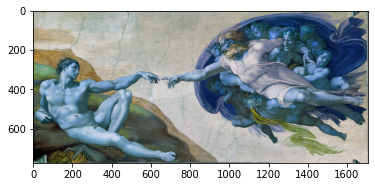

In [220]:
plt.imshow(img_test)